This notebook is designed to show how to use the cratersfd package to do crater age calculations for the Moon.

Here, we load the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random
import pickle as pkl
from cratersfd import *
%matplotlib inline

For our example data, we will use the counts of the Apollo 15 landing site from Robbins et al. (2014) provided by Stuart Robbins.  They come from LROC NAC image M146959973L.  The diameters are in units of pixels, and an adjustment is made for pixel size.

In [2]:
cfactor = np.cos(math.pi * (26 + 11 / 60) / 180) * 0.626608880720610
rawd = pd.read_csv('../data/M146959973L.txt', delimiter='\t') * cfactor
ds = np.array(sorted(rawd['D_wm'].tolist())) / 1000
w = 4000 * cfactor / 1000
h = 2215 * cfactor / 1000
area = h * w

Let's start by plotting our data on a differential plot with the SASH algorithm.  

This curve displays a classic equilibrium saturation pattern, a steeper slope for large craters, rolling over to a shallower slope for small craters.  The shallow slope is caused by crater saturation, and the steeper slope reflects the production function.  For the sake of this example, let us assume that this slope change is statistically significant, and the SFD actually does extend to diameters large enough to be unsaturated, allowing us to get an age.  With that assumption, we will demonstrate how to calculate an age.

1.03429 seconds


(1.0, 100000.0)

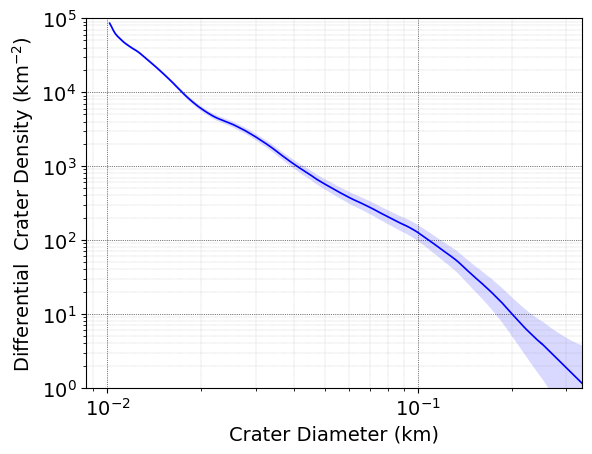

In [3]:
X, Y = plot_sash(
    ds, area, color='blue',
    bin_width_exponent=neukum_bwe, 
    growth_rate=1.2, n_points=10000, n_shifts=200,
    error_bin_width_exponent=per_decade(5)
)
plt.ylim([1E0, 1E5])

Next, let's plot the data on an R plot, which emphasizes changes in slope.

Calculation time: 1.26876 seconds


(0.019, 0.21)

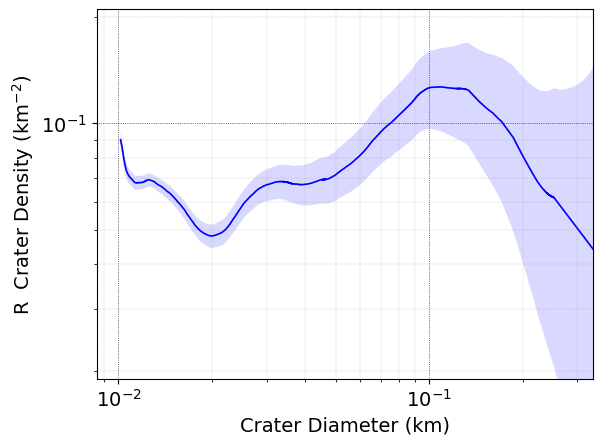

In [4]:
X, R = plot_sash_R(
    ds, area, color='blue',
    bin_width_exponent=neukum_bwe, 
    growth_rate=1.2, n_points=10000, n_shifts=200,
    error_bin_width_exponent=per_decade(5)
)
plt.ylim([1.9E-2, 2.1E-1])

This crater distribution is saturated over most of its range, but it does appear to exit saturation at the highest diameters.  To calculate a date, we first have to estimate $D_{{min}}$.  That's the diameter where the SFD is no longer depressed by saturation.  To help choose this diameter, we plot alpha, the negative cumulative slope, from the output of our differential SASH plot.

(0.5, 4.0)

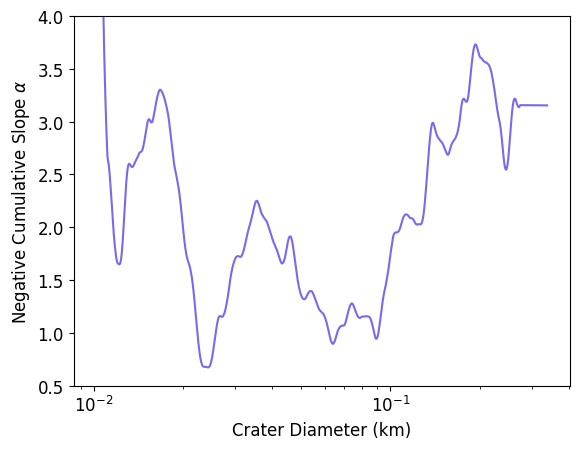

In [5]:
plot_sash_alpha(
    X, Y, window_length=500, polyorder=5, deriv=1
)
plt.ylim([0.5, 4])

There aren't really any clear standards about where to choose $D_{{min}}$.  Initially, let's start by picking a single estimate for $D_{{min}}$ to demonstrate how to calculate a PDF of age for a given $D_{{min}}$.  Here, we choose a diameter where the slope has clearly transitioned out of saturation: $D_{{min}} = 0.14km$.

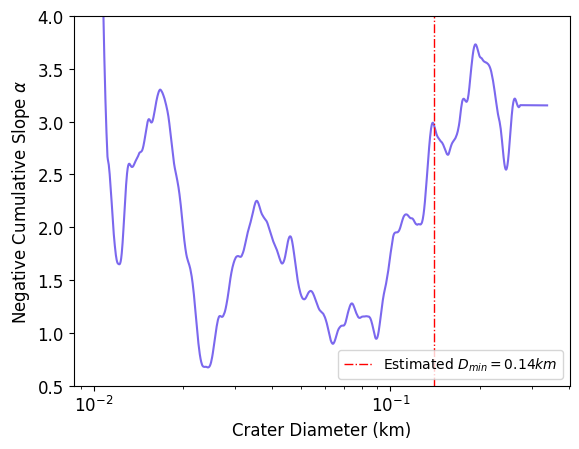

In [6]:
plot_sash_alpha(
    X, Y, window_length=500, polyorder=5, deriv=1
)
plt.ylim([0.5, 4])

dmin_estimate = 0.14

plt.plot(
    [dmin_estimate, dmin_estimate], [0.5, 4.0], 'r-.',
    lw=1, label=rf'Estimated $D_{{min}} = 0.14km$'
)

plt.legend()

To calculate and plot the PDF of age, we use the one-line function age_pdf().  The age_pdf() function returns a RandomVariable object, whose PDF we can plot with its .plot() method.

Text(0.5, -7.277777777777782, 'Age (Ga)')

<Figure size 640x480 with 0 Axes>

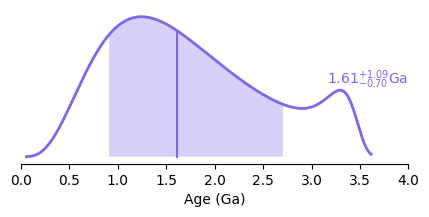

In [7]:
age_pdf(ds, area, dmin_estimate).plot(
    label=True, unit='Ga', xlim=[0, 4.0]
)
plt.xlabel('Age (Ga)')

Here are its default values.  It assumes the Neukum Production Function and the Neukum Chronology Function, and it defaults to plotting median method error bars.  It assumes no chronology function or production function error.

It assumes three lognormally distributed error distributions with percentage errors:

Random human crater counting error: 50% (factor of 1.5)

Systematic human crater counting error: 10% (factor of 1.1)

Statistical error from deviations from the Poisson assumption: 20% (factor of 1.2)

Text(0.5, -7.277777777777782, 'Age (Ga)')

<Figure size 640x480 with 0 Axes>

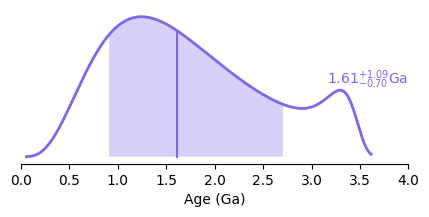

In [8]:
age_pdf(
    ds, area, dmin_estimate, pf=npf_new, cf_inv=ncf_inv, kind='median',
    lambda_error=None, d_error=1.01, pf_error=1.0, npl=2000, cf_error=1.0,
    random=1.5, systematic=1.1, statistical=1.2
).plot(
    label=True, unit='Ga', xlim=[0, 4.0]
)
plt.xlabel('Age (Ga)')

This result should trouble us.  Because this image shows the Apollo 15 landing site, it's a chronology function calibration terrain.  Its age was dated at 3.29±0.01Ga from returned samples (Snape et al., 2019).  Although it is possible that it is an outlier, this age is broadly inconsistent with the known age.

Text(0.5, -7.277777777777782, 'Age (Ga)')

<Figure size 640x480 with 0 Axes>

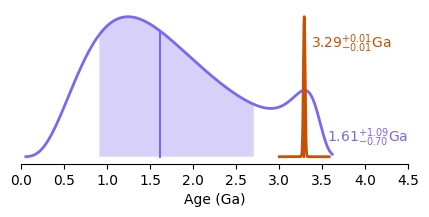

In [9]:
s19X = np.linspace(3, 3.58, 10000)
s19P = norm.pdf(s19X, 3.29, 0.01)
age_rv_snape_et_al_2019 = RandomVariable(
    s19X, s19P, kind='median'
)

age_pdf(ds, area, dmin_estimate).plot(
    label=True, unit='Ga', xlim=[0, 4.5]
)
age_rv_snape_et_al_2019.plot(
    color=cs[5], label=True, unit='Ga',
    force_label_side='right', label_shift_y=0.7,
    label_shift_x=-0.2
)
plt.xlabel('Age (Ga)')

To help explain this result, let's consider the possibility that our initial estimate of $D_{{min}}$ was off.  If we choose $D_{{min}} = 0.15km$ instead of $D_{{min}} = 0.14km$, the known age is just barely outside the upper bound, making it a very plausible outlier.

Text(0.5, -7.277777777777782, 'Age (Ga)')

<Figure size 640x480 with 0 Axes>

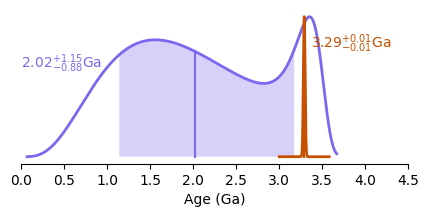

In [10]:
age_pdf(ds, area, 0.15).plot(
    label=True, unit='Ga', xlim=[0, 4.5]
)
age_rv_snape_et_al_2019.plot(
    color=cs[5], label=True, unit='Ga',
    force_label_side='right', label_shift_y=0.7,
    label_shift_x=-0.2
)
plt.xlabel('Age (Ga)')

The truth is that $D_{{min}}$ is not perfectly known.  It is, in fact, a random variable.  To address this, instead of taking a single value for $D_{{min}}$, age_pdf() can take a RandomVariable object that defines a PDF of $D_{{min}}$.  Here, we estimate a plausible PDF of $D_{{min}}$ and quantify it as a RandomVariable object in the variable dmin_rv.

<Figure size 640x480 with 0 Axes>

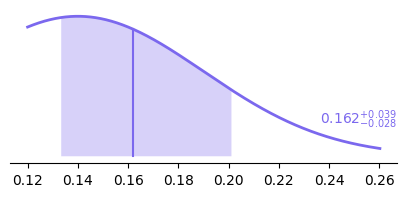

In [11]:
X = np.linspace(0.12, np.max(ds), 10000)
P = norm.pdf(X, 0.14, 0.05)
dmin_rv = RandomVariable(X, P, kind='median')
dmin_rv.plot(label=True)

When we apply the $D_{{min}}$ PDF, the known age falls right at the upper bound.

Text(0.5, -7.277777777777782, 'Age (Ga)')

<Figure size 640x480 with 0 Axes>

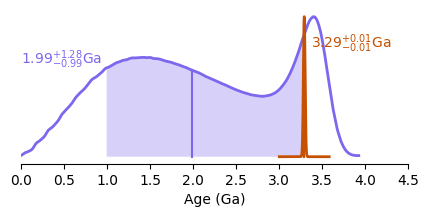

In [12]:
age_pdf(ds, area, dmin_rv).plot(
    label=True, unit='Ga', xlim=[0, 4.5]
)
age_rv_snape_et_al_2019.plot(
    color=cs[5], label=True, unit='Ga',
    force_label_side='right', label_shift_y=0.7,
    label_shift_x=-0.2
)
plt.xlabel('Age (Ga)')

## Step by step breakdown

Let's break down step by step how age_pdf() works.  First, we calculate $N$ from $D_{{min}}$.

In [13]:
N = ds[ds > dmin_estimate].shape[0]
N

4

Note: age_pdf() can take a single value of $N$ instead of a list of diameters.

Text(0.5, -7.277777777777782, 'Age (Ga)')

<Figure size 640x480 with 0 Axes>

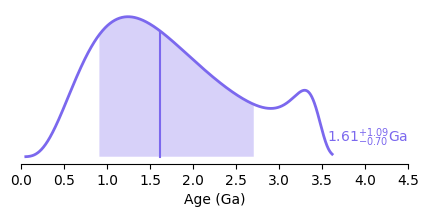

In [14]:
age_pdf(N, area, dmin_estimate).plot(
    label=True, unit='Ga', xlim=[0, 4.5]
)
plt.xlabel('Age (Ga)')

Next, we set the pf (production function) and cf_inv (inverse chronology function) equal to npf_new and ncf_inv, the defaults for age_pdf.  The NPF (Neukum Production Function) and NCF (Neukum Chronology Function) represent the production and chronology functions that define the Neukum chronology system for the Moon (Neukum, 1983; Neukum et al., 2001).  The "New NPF," represented by npf_new, is an update (Neukum et al., 2001) to the Neukum (1983) production function.  The NCF is written as a function that takes an age and gives an N(1) value.  The inverse NCF, represented by ncf_inv, is the function that translates N(1) values to age.  The inverse function cannot be solved analytically, so ncf_inv implements a numerical inverse function of the NCF.

In [15]:
pf = npf_new
cf_inv = ncf_inv

Then, we calculate the likelihood PDF of the model crater count $\lambda$ using the lambda_pdf function, which returns a RandomVariable object that defaults to log method errors.

Text(0.5, -7.277777777777782, 'Model Crater Count $\\lambda$')

<Figure size 640x480 with 0 Axes>

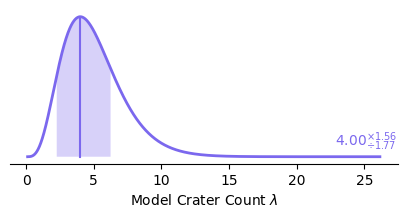

In [16]:
lambda_rv = lambda_pdf(N)
lambda_rv.plot(
    label=True#, xlim=[5, 40]
)
plt.xlabel(r'Model Crater Count $\lambda$')

Now, let's change the error bar method to the median method.

Text(0.5, -7.277777777777782, 'Model Crater Count $\\lambda$')

<Figure size 640x480 with 0 Axes>

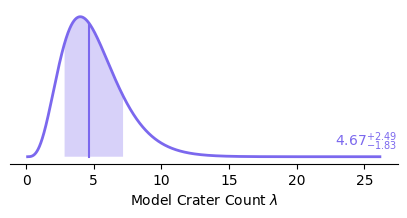

In [17]:
lambda_rv = lambda_rv.as_kind('median')
lambda_rv.plot(
    label=True#, xlim=[5, 40]
)
plt.xlabel(r'Model Crater Count $\lambda$')

Next, we calculate the error PDF for $\lambda$.  With the lambda_error_lognormal() function, we combine 50% random error, 10% systematic error, and 20% statistical error for our value of $N$.  ($N$ matters because it decreases random error.)  The lambda_error_lognormal() function applies the lognormal quadrature rule to combine these error factors.

Once we have the error factor, we convert it to a lognormal random variable with the apply_factor() function.

Combined error factor: 1.3348714835894762


<Figure size 640x480 with 0 Axes>

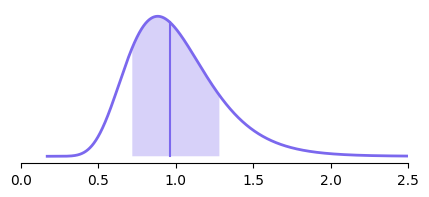

In [18]:
lambda_error_factor = lambda_error_lognormal(
    N, random=1.5, systematic=1.1, statistical=1.2
)
print('Combined error factor: ' + str(lambda_error_factor))
lambda_error = apply_factor(1, lambda_error_factor)
lambda_error.plot(xlim=[0, 2.5])

Then we multiply the $\lambda$ PDF by the error PDF.

In [19]:
lambda_rv_with_error = lambda_rv * lambda_error

Next, we convert the $\lambda$ PDF to a crater density PDF by dividing by area.

Text(0.5, -7.277777777777782, 'Crater Density (craters/km$^2$)')

<Figure size 640x480 with 0 Axes>

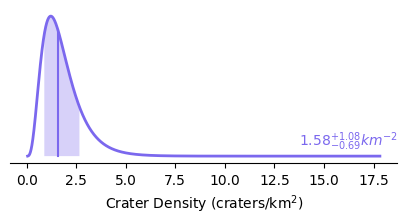

In [20]:
crater_density_rv = lambda_rv_with_error / area
crater_density_rv.plot(
    label=True, unit=r'$km^{-2}$',# xlim=[2, 14],
)
plt.xlabel(r'Crater Density (craters/km$^2$)')

Then, we use the production function (the NPF) to project our crater density PDF to an N(1) PDF.

Text(0.5, -7.277777777777782, 'N(1) (craters/km$^2$)')

<Figure size 640x480 with 0 Axes>

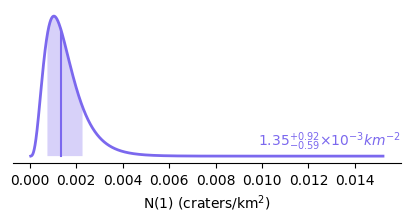

In [21]:
N1_shift = pf(1) / pf(dmin_estimate)
N1_rv = crater_density_rv * N1_shift
N1_rv.plot(
    label=True,# xlim=[5.3E-4, 4.2E-3],
    unit=r'$km^{-2}$',
)
plt.xlabel(r'N(1) (craters/km$^2$)')

Finally, we use the apply2rv function to apply the inverse production function (the inverse NCF) to the N(1) PDF to produce an age pdf.

Text(0.5, -7.277777777777782, 'Age (Ga)')

<Figure size 640x480 with 0 Axes>

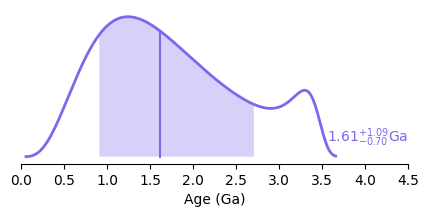

In [22]:
age_rv = apply2rv(N1_rv, cf_inv)
age_rv.plot(label=True, unit='Ga', xlim=[0, 4.5])
plt.xlabel('Age (Ga)')